In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [3]:
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = cancer.target

df.tail()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0
568,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,...,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.0000,0.2871,0.07039,1


In [4]:
df.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension',
       'class'],
      dtype='object')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [86]:
data = torch.from_numpy(df.values).float()

data.shape

torch.Size([569, 31])

In [87]:
x = data[:, :10]
y = data[:, -1:]

x.shape, y.shape

(torch.Size([569, 10]), torch.Size([569, 1]))

In [88]:
ratios = [.6, .2, .2]

In [89]:
train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = x.size(0) - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]

train_cnt, valid_cnt, test_cnt

(341, 113, 115)

In [90]:
indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = x.split(cnts, dim=0)
y = y.split(cnts, dim=0)

for x_i, y_i in zip(x, y):
    print(x_i.shape, y_i.shape)

torch.Size([341, 10]) torch.Size([341, 1])
torch.Size([113, 10]) torch.Size([113, 1])
torch.Size([115, 10]) torch.Size([115, 1])


In [102]:
n_epochs = 10000
batch_size = 128
print_interval = 500
early_stop = 200

In [103]:
from torch.utils.data import Dataset, DataLoader

In [104]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
        super().__init__()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [105]:
train_loader = DataLoader(
    dataset=CustomDataset(x[0], y[0]),
    batch_size=batch_size,
    shuffle=True
)
valid_loader = DataLoader(
    dataset=CustomDataset(x[1], y[1]),
    batch_size=batch_size,
    shuffle=False
)
test_loader = DataLoader(
    dataset=CustomDataset(x[2], y[2]),
    batch_size=batch_size,
    shuffle=False
)

In [106]:
print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset),
    len(valid_loader.dataset),
    len(test_loader.dataset)
))

Train 341 / Valid 113 / Test 115 samples.


In [107]:
model = nn.Sequential(
    nn.Linear(x[0].size(-1), 6),
    nn.LeakyReLU(),
    nn.BatchNorm1d(6),
    nn.Linear(6, 5),
    nn.LeakyReLU(),
    nn.BatchNorm1d(5),
    nn.Linear(5, 4),
    nn.LeakyReLU(),
    nn.BatchNorm1d(4),
    nn.Linear(4, 3),
    nn.LeakyReLU(),
    nn.BatchNorm1d(3),
    nn.Linear(3, y[0].size(-1)),
    nn.Sigmoid(),
)

model

Sequential(
  (0): Linear(in_features=10, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=6, out_features=5, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=5, out_features=4, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Linear(in_features=4, out_features=3, bias=True)
  (10): LeakyReLU(negative_slope=0.01)
  (11): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Linear(in_features=3, out_features=1, bias=True)
  (13): Sigmoid()
)

In [108]:
optimizer = optim.Adam(model.parameters())

In [109]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

lowest_epoch = np.inf

In [110]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    train_loss, valid_loss = 0, 0
    y_hat = []
    
    for x_i, y_i in train_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
    train_loss = train_loss / len(train_loader)
    
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        
        for x_i, y_i in valid_loader:
            y_hat_i = model(x_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)
            
            valid_loss += float(loss)
            y_hat += [y_hat_i]
            
    valid_loss = valid_loss / len(valid_loader)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train_loss=%.4e  valid_loss=%.4e  test_loss=%.4e' % (
            i + 1,
            train_loss,
            valid_loss,
            lowest_loss
        ))
        
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        best_model = deepcopy(model.state_dict())
        lowest_epoch = i
    else :
        if early_stop > 0 and early_stop + lowest_epoch < i + 1 :
            print('There is no improvement during last %d epochs.' % early_stop)
            break

            
print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))
model.load_state_dict(best_model)

Epoch 500: train_loss=1.1548e-01  valid_loss=7.5817e-01  test_loss=9.4558e-02
Epoch 1000: train_loss=1.4099e-01  valid_loss=4.8920e-01  test_loss=8.7090e-02
Epoch 1500: train_loss=1.3061e-01  valid_loss=1.1260e-01  test_loss=8.1861e-02
There is no improvement during last 200 epochs.
The best validation loss from epoch 1605: 7.7165e-02


<All keys matched successfully>

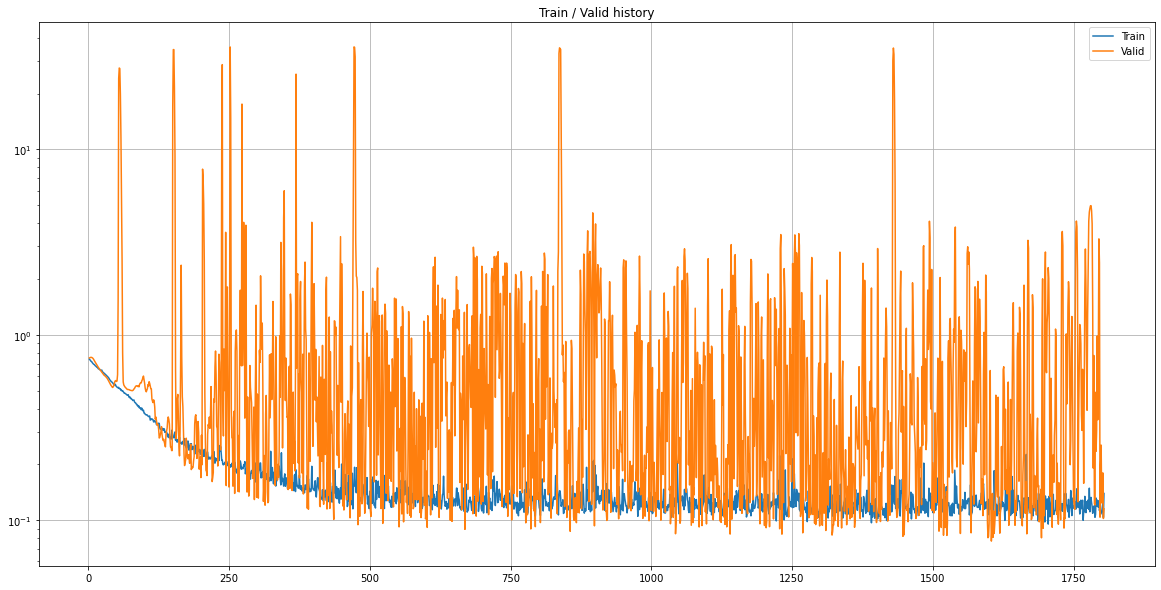

In [111]:
plot_from = 2

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title('Train / Valid history')
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid')

plt.yscale('log')
plt.legend()
plt.show()

In [112]:
test_loss = 0
y_hat = []

with torch.no_grad():
    
    for x_i, y_i in test_loader:
        y_hat_i = model(x_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)
        
        test_loss += float(loss)
        y_hat += [y_hat_i]
test_loss = test_loss / len(test_loader)
y_hat = torch.cat(y_hat, dim=0)

print('Test loss: %.4e' % test_loss)

Test loss: 1.6599e-01


In [113]:
correct_cnt = (y[2] == (y_hat > .5)).sum()
total_cnt = float(y[2].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9217
